In [0]:
#danaderp May6'19
#Prediction For Main Issues Data Set

In [0]:
import csv
from tensorflow.keras.preprocessing import text
from nltk.corpus import gutenberg
from string import punctuation
from tensorflow.keras.preprocessing.sequence import skipgrams

/scratch/danaderp/.conda/envs/drmccr_conda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Limited tf.compat.v2.summary API due to missing TensorBoard installation
Limited tf.summary API due to missing TensorBoard installation


In [0]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = 200
%matplotlib inline

In [0]:
from nltk.stem.snowball import SnowballStemmer
englishStemmer=SnowballStemmer("english")

In [0]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dot, Input, Dense, Reshape, LSTM, Conv2D, Flatten, MaxPooling1D, Dropout, MaxPooling2D
from tensorflow.keras.layers import Embedding, Multiply, Subtract
from tensorflow.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Lambda
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint

In [0]:
# visualize model structure
#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import TSNE

In [0]:
from datasets.read_data import Dynamic_Dataset,Processing_Dataset
from vectorize_sentence import Embeddings

In [0]:
path = "datasets/combined_dataset/"
process_unit = Processing_Dataset(path)
ground_truth = process_unit.get_ground_truth()

In [0]:
dataset = Dynamic_Dataset(ground_truth, path)

In [0]:
test, train = process_unit.get_test_and_training(ground_truth)

In [0]:
print(len(test))
print(len(train))
print(test[0])
print(train[0])

1030
9308
('(1,0)', "[Security] Deprecated not being logged out after user change\n\n\n\n\n\nQ\nA\n\n\n\n\nBranch?\n3.4\n\n\nBug fix?\nyes\n\n\nNew feature?\nno\n\n\nBC breaks?\nno\n\n\nDeprecations?\nyes\n\n\nTests pass?\nyes\n\n\nFixed tickets\n#17023\n\n\nLicense\nMIT\n\n\nDoc PR\n~\n\n\n\nThis PR is an alternative approach to #19033. Due to a behavioral change that could break a lot of applications and websites, I've decided to trigger a deprecation instead of actually changing the behavior as that can be done for 4.0.\nWhenever a user object is considered changed (AbstractToken::hasUserChanged) when setting a new user object after refreshing, it will now throw a deprecation, paving the way for a behavioral change in 4.0. The idea is that in 4.0 Symfony will simply trigger a logout when this case is encountered.")
('(1,0)', 'The currently used Rails version, in the stable branch, is insecure\n\nYou should update the Gemfile.lock to hotfix this.\n\nhttp://weblog.rubyonrails.org/2014

In [0]:
#Train/Test split verification
#for elem in test:
#    print(elem[0])

In [0]:
#Preprocesing Corpora
embeddings = Embeddings()
max_words = 5000 #<------- [Parameter]
pre_corpora_train = [doc for doc in train if len(doc[1])< max_words]
pre_corpora_test = [doc for doc in test if len(doc[1])< max_words]

In [0]:
print(len(pre_corpora_train))
print(len(pre_corpora_test))

9052
994


In [0]:
embed_path = 'datasets/word_embeddings-embed_size_100-epochs_100.csv'
embeddings_dict = embeddings.get_embeddings_dict(embed_path)

In [0]:
corpora_train = [embeddings.vectorize(doc[1], embeddings_dict) for doc in pre_corpora_train]#vectorization Inputs
corpora_test = [embeddings.vectorize(doc[1], embeddings_dict) for doc in pre_corpora_test]#vectorization

In [0]:
target_train = [[int(list(doc[0])[1]),int(list(doc[0])[3])] for doc in pre_corpora_train]#vectorization Output
target_test = [[int(list(doc[0])[1]),int(list(doc[0])[3])]for doc in pre_corpora_test]#vectorization Output
#target_train

In [0]:
max_len_sentences_train = max([len(doc) for doc in corpora_train]) #<------- [Parameter]
max_len_sentences_test = max([len(doc) for doc in corpora_test]) #<------- [Parameter]

In [0]:
max_len_sentences = max(max_len_sentences_train,max_len_sentences_test)
print("Max. Sentence # words:",max_len_sentences)

Max. Sentence # words: 588


In [0]:
min_len_sentences_train = min([len(doc) for doc in corpora_train]) #<------- [Parameter]
min_len_sentences_test = min([len(doc) for doc in corpora_test]) #<------- [Parameter]

In [0]:
min_len_sentences = max(min_len_sentences_train,min_len_sentences_test)
print("Mix. Sentence # words:",min_len_sentences)

Mix. Sentence # words: 1


In [0]:
embed_size = np.size(corpora_train[0][0])

In [0]:
#BaseLine Architecture <-------
embeddigs_cols = embed_size
input_sh = (max_len_sentences,embeddigs_cols,1)
#Selecting filters? 
#https://stackoverflow.com/questions/48243360/how-to-determine-the-filter-parameter-in-the-keras-conv2d-function
#https://stats.stackexchange.com/questions/196646/what-is-the-significance-of-the-number-of-convolution-filters-in-a-convolutional

N_filters = 128 # <-------- [HyperParameter] Powers of 2 Numer of Features
K = 2 # <-------- [HyperParameter] Number of Classess

In [0]:
input_sh

(588, 100, 1)

In [0]:
#baseline_model = Sequential()
gram_input = Input(shape = input_sh)

In [0]:
# 1st Convolutional Layer
conv_1_layer = Conv2D(filters=64, input_shape=input_sh, activation='relu', 
                      kernel_size=(7,7), strides=(2,2), padding='valid')(gram_input)

In [0]:
conv_1_layer.shape

TensorShape([None, 291, 47, 64])

In [0]:
# Max Pooling
max_1_pooling = MaxPooling2D(pool_size=(3,3), strides=None, padding='valid')(conv_1_layer)

In [0]:
max_1_pooling.shape

TensorShape([None, 97, 15, 64])

In [0]:
# 2nd Convolutional Layer
conv_2_layer = Conv2D(filters=256, kernel_size=(5,5), activation='relu', 
                      strides=(1,1), padding='valid')(max_1_pooling)

In [0]:
conv_2_layer.shape

TensorShape([None, 93, 11, 256])

In [0]:
# Max Pooling
max_2_pooling = MaxPooling2D(pool_size=(3,3), strides=None, padding='valid')(conv_2_layer)

In [0]:
max_2_pooling.shape

TensorShape([None, 31, 3, 256])

In [0]:
# 3rd Convolutional Layer
conv_3_layer =  Conv2D(filters=512, kernel_size=(3,3), activation='relu', 
                      strides=(1,1), padding='valid')(max_2_pooling)

In [0]:
conv_3_layer.shape

TensorShape([None, 29, 1, 512])

In [0]:
# 4th Convolutional Layer
conv_4_layer = Conv2D(filters=512, kernel_size=(3,1), activation='relu', 
                      strides=(1,1), padding='valid')(conv_3_layer)

In [0]:
conv_4_layer.shape

TensorShape([None, 27, 1, 512])

In [0]:
# 5th Convolutional Layer
conv_5_layer = Conv2D(filters=256, kernel_size=(3,1), activation='relu', 
                      strides=(1,1), padding='valid')(conv_4_layer)

In [0]:
conv_5_layer.shape

TensorShape([None, 25, 1, 256])

In [0]:
# Max Pooling
max_5_pooling = MaxPooling2D(pool_size=(3,1), strides=None, padding='valid')(conv_5_layer)

In [0]:
max_5_pooling.shape

TensorShape([None, 8, 1, 256])

In [0]:
# Fully Connected layer
fully_connected = Flatten()(max_5_pooling)

In [0]:
fully_connected.shape

TensorShape([None, 2048])

In [0]:
# 1st Fully Connected Layer
deep_dense_1_layer = Dense(1024, activation='relu')(fully_connected)
deep_dense_1_layer = Dropout(0.4)(deep_dense_1_layer) # <-------- [HyperParameter]

In [0]:
deep_dense_1_layer.shape

TensorShape([None, 1024])

In [0]:
# 2nd Fully Connected Layer
deep_dense_2_layer = Dense(1024, activation='relu')(deep_dense_1_layer)
deep_dense_2_layer = Dropout(0.4)(deep_dense_2_layer) # <-------- [HyperParameter]

In [0]:
deep_dense_2_layer.shape

TensorShape([None, 1024])

In [0]:
# 3rd Fully Connected Layer
deep_dense_3_layer = Dense(128, activation='relu')(deep_dense_2_layer)
deep_dense_3_layer = Dropout(0.4)(deep_dense_3_layer) # <-------- [HyperParameter]

In [0]:
deep_dense_3_layer.shape

TensorShape([None, 128])

In [0]:
predictions = Dense(K, activation='softmax')(deep_dense_3_layer)

In [0]:
#Criticality Model
criticality_network = Model(inputs=[gram_input],outputs=[predictions]) 

In [0]:
print(criticality_network.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 588, 100, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 291, 47, 64)       3200      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 97, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 93, 11, 256)       409856    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 3, 256)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 1, 512)        1180160   
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 1, 512)        786944

In [0]:
#Seting up the Model
criticality_network.compile(optimizer='adam',loss='binary_crossentropy',
                                  metrics=['accuracy'])

In [0]:
#Data set organization
from tempfile import mkdtemp
import os.path as path

In [0]:
#Memoization 
file_corpora_train_x = path.join(mkdtemp(), 'alex-res_temp_corpora_train_x.dat') #Update per experiment
file_corpora_test_x = path.join(mkdtemp(), 'alex-res_temp_corpora_test_x.dat')

In [0]:
#Shaping
shape_train_x = (len(corpora_train),max_len_sentences,embeddigs_cols,1)
shape_test_x = (len(corpora_test),max_len_sentences,embeddigs_cols,1)

In [0]:
#Data sets
corpora_train_x = np.memmap(
        filename = file_corpora_train_x, 
        dtype='float32', 
        mode='w+', 
        shape = shape_train_x)

In [0]:
corpora_test_x = np.memmap( #Test Corpora (for future evaluation)
        filename = file_corpora_test_x, 
        dtype='float32', 
        mode='w+', 
        shape = shape_test_x)

In [0]:
target_train_y = np.array(target_train) #Train Target
target_test_y = np.array(target_test) #Test Target (for future evaluation)

In [0]:
corpora_train_x.shape

(9052, 588, 100, 1)

In [0]:
target_train_y.shape

(9052, 2)

In [0]:
corpora_test_x.shape

(994, 588, 100, 1)

In [0]:
target_test_y.shape

(994, 2)

In [0]:
#Reshaping Train Inputs
for doc in range(len(corpora_train)):
    #print(corpora_train[doc].shape[1])
    for words_rows in range(corpora_train[doc].shape[0]):
        embed_flatten = np.array(corpora_train[doc][words_rows]).flatten() #<--- Capture doc and word
        for embedding_cols in range(embed_flatten.shape[0]):
            corpora_train_x[doc,words_rows,embedding_cols,0] = embed_flatten[embedding_cols]

In [0]:
#Reshaping Test Inputs (for future evaluation)
for doc in range(len(corpora_test)):
    for words_rows in range(corpora_test[doc].shape[0]):
        embed_flatten = np.array(corpora_test[doc][words_rows]).flatten() #<--- Capture doc and word
        for embedding_cols in range(embed_flatten.shape[0]):
            corpora_test_x[doc,words_rows,embedding_cols,0] = embed_flatten[embedding_cols]

In [0]:
#CheckPoints
#csv_logger = CSVLogger(system+'_training.log')
filepath = "alex-res/embeds100-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath)
callbacks_list = [checkpoint]

In [0]:
#Model Fitting
history = criticality_network.fit(
            x = corpora_train_x, 
            y = target_train_y,
            #batch_size=64,
            epochs=20, #5 <------ Hyperparameter
            validation_split = 0.2
            #callbacks=callbacks_list
)

Train on 7241 samples, validate on 1811 samples
Epoch 1/20
7241/7241 [==============================] - 107s 15ms/sample - loss: 0.6629 - accuracy: 0.5792 - val_loss: 0.4899 - val_accuracy: 0.8504
Epoch 2/20
7241/7241 [==============================] - 103s 14ms/sample - loss: 0.5638 - accuracy: 0.7039 - val_loss: 0.6550 - val_accuracy: 0.4970
Epoch 3/20
7241/7241 [==============================] - 104s 14ms/sample - loss: 0.5212 - accuracy: 0.7433 - val_loss: 0.5116 - val_accuracy: 0.7863
Epoch 4/20
7241/7241 [==============================] - 103s 14ms/sample - loss: 0.4909 - accuracy: 0.7673 - val_loss: 0.6165 - val_accuracy: 0.5842
Epoch 5/20
7241/7241 [==============================] - 100s 14ms/sample - loss: 0.4724 - accuracy: 0.7752 - val_loss: 0.5158 - val_accuracy: 0.6615
Epoch 6/20
7241/7241 [==============================] - 100s 14ms/sample - loss: 0.4451 - accuracy: 0.7992 - val_loss: 0.5139 - val_accuracy: 0.7294
Epoch 7/20
7241/7241 [==============================] - 90

In [0]:
#Saving Training History
df_history = pd.DataFrame.from_dict(history.history)
df_history.to_csv('alex-res/history_training.csv', encoding='utf-8',index=False)

In [0]:
criticality_network.save(filepath)
df_history.head()

,accuracy,loss,val_accuracy,val_loss
0,0.579202,0.662911,0.850359,0.489930
1,0.703908,0.563793,0.496963,0.655045
2,0.743267,0.521162,0.786306,0.511641
3,0.767297,0.490945,0.584208,0.616510
4,0.775169,0.472416,0.661513,0.515818


In [0]:
#Saving Test Data
np.save('alex-res/corpora_test_x.npy',corpora_test_x)
np.save('alex-res/target_test_y.npy',target_test_y)

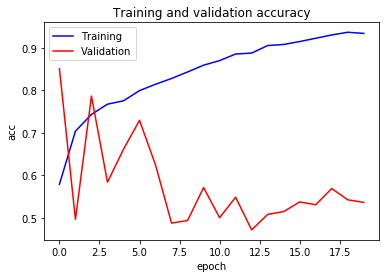

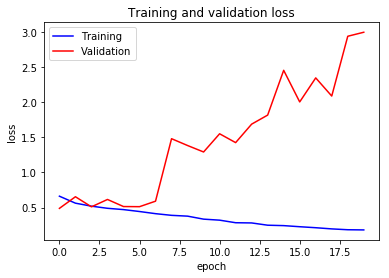

In [0]:
#Evaluation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs2 = range(len(acc))
 
plt.plot(epochs2, acc, 'b', label='Training')
plt.plot(epochs2, val_acc, 'r', label='Validation')
plt.title('Training and validation accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend()
 
plt.figure()
 
plt.plot(epochs2, loss, 'b', label='Training')
plt.plot(epochs2, val_loss, 'r', label='Validation')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
 
plt.show()